<a href="https://colab.research.google.com/github/Dhyanav/BrainSpy/blob/main/Edge_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


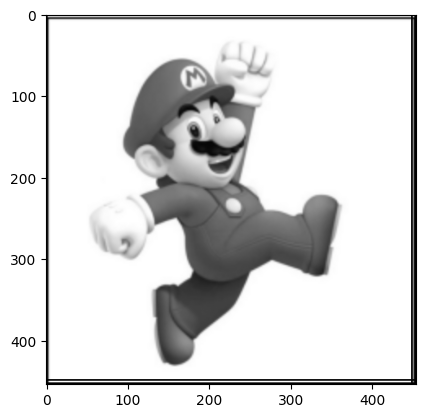

In [ ]:
path = "/content/drive/MyDrive/BrainSpy_BCS/Week_1/Mario.png"

img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

n = min(img.shape[0], img.shape[1])
img = img[:n, :n]

#print(img.shape)

## Padding for gaussian blur
image = np.zeros( [n+4, n+4] )
for i in range(n):
  for j in range(n):
    image[i+2, j+2] = img[i, j]

image[:n+4, 0] = 0
image[:n+4, 1] = 0
image[:n+4, n-1] = 0
image[:n+4, n-2] = 0

image[0, :n+4] = 0
image[1, :n+4] = 0
image[n-1, :n+4] = 0
image[n-2, :n+4] = 0

#print(image.shape)

image = image / 255

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
def apply_filter(image, kernel): # Square Matrix Required
  size_img = image.shape[0]
  size_kernel = kernel.shape[0]
  size = size_img - size_kernel + 1
  conv_matrix = np.zeros([size, size])

  for i in range(size):
    for j in range(size):
      conv_matrix[i, j] = np.sum( kernel * image[i:i+size_kernel, j:j+size_kernel] )

  return conv_matrix

# Canny-Edge

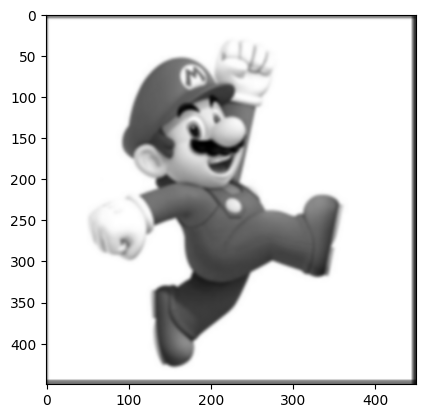

In [67]:
## Gaussian blur

gaussian = np.zeros([5, 5])
sigma = 2
k = 2 # 5 = 2k + 1
for i in range(5):
  for j in range(5):
    a = (i - k ) ** 2
    b = (j - k ) ** 2
    gaussian[i, j] = 1/(2*math.pi* (sigma)**2 ) * math.exp( -( a+b )/( 2*(sigma**2) ) )

gaussian = gaussian / gaussian.sum()

img_blurred = apply_filter(image, gaussian)

plt.imshow(img_blurred, cmap='gray')
plt.show()

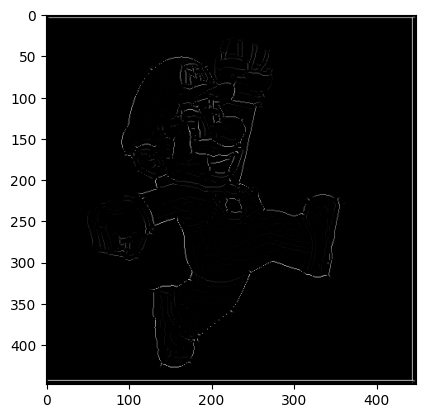

In [68]:
H, W = img_blurred.shape
edge_strength = np.zeros((H-2, W-2))
dir_map = np.zeros((H-2, W-2))

## gradients and theta computation
for i in range(1, H-1):
    for j in range(1, W-1):
        g_x = img_blurred[i, j+1] - img_blurred[i, j-1]
        g_y = img_blurred[i+1, j] - img_blurred[i-1, j]
        g = math.hypot(g_x, g_y)
        theta = math.degrees(math.atan2(g_y, g_x)) % 180  # Wrap around to [0,180)

        if (0 <= theta < 22.5) or (157.5 <= theta < 180):
            quantized = 0
        elif 22.5 <= theta < 67.5:
            quantized = 45
        elif 67.5 <= theta < 112.5:
            quantized = 90
        else:
            quantized = 135

        edge_strength[i-1, j-1] = g
        dir_map[i-1, j-1] = quantized

# non-maximum suppression
non_max_sup = np.zeros_like(edge_strength)
H2, W2 = edge_strength.shape

for i in range(1, H2-1):
    for j in range(1, W2-1):
        angle = dir_map[i, j]
        mag = edge_strength[i, j]

        if angle == 0:
            before = edge_strength[i, j-1]
            after = edge_strength[i, j+1]
        elif angle == 45:
            before = edge_strength[i-1, j+1]
            after = edge_strength[i+1, j-1]
        elif angle == 90:
            before = edge_strength[i-1, j]
            after = edge_strength[i+1, j]
        elif angle == 135:
            before = edge_strength[i-1, j-1]
            after = edge_strength[i+1, j+1]

        if mag >= before and mag >= after:
            non_max_sup[i, j] = mag
        else:
            non_max_sup[i, j] = 0


plt.imshow(non_max_sup, cmap='gray')
plt.show()

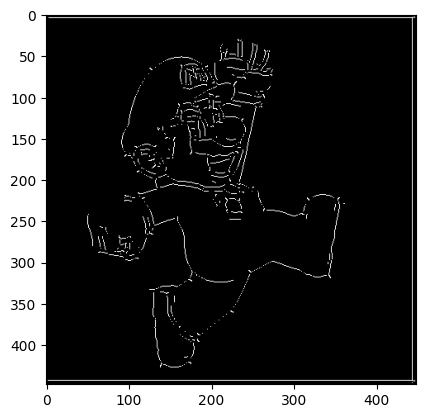

In [71]:
low_threshold = 0.02
high_threshold = 0.04

strength_map = np.zeros(non_max_sup.shape)

## thresholding
for i in range(non_max_sup.shape[0]):
    for j in range(non_max_sup.shape[1]):
        val = non_max_sup[i, j]
        if val >= high_threshold:
            strength_map[i, j] = 2  # strong edge
        elif val >= low_threshold:
            strength_map[i, j] = 1  # weak edge
        else:
            strength_map[i, j] = 0  # non-edge

## hytersis
for i in range(1, strength_map.shape[0]-1):
    for j in range(1, strength_map.shape[1]-1):
        if strength_map[i, j] == 1:  # weak edge
            # If any neighbor is strong edge, promote to strong
            if 2 in strength_map[i-1:i+2, j-1:j+2]:
                strength_map[i, j] = 2
            else:
                strength_map[i, j] = 0  # suppress weak edge

plt.imshow(strength_map, cmap='gray')
plt.show()

# Sobel Filter

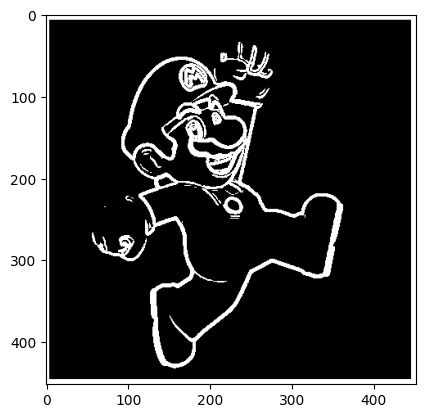

In [ ]:
sobel_filter_x = [ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1] ]
sobel_filter_x = np.array(sobel_filter_x)

image_sobel_x = apply_filter(image, sobel_filter_x) ## will also store final result

sobel_filter_y = [ [-1, -2, -1], [0, 0, 0], [1, 2, 1] ]
sobel_filter_y = np.array(sobel_filter_y)

image_sobel_y = apply_filter(image, sobel_filter_y)

threshold = 0.3

for i in range(image_sobel_x.shape[0]):
  for j in range(image_sobel_x.shape[1]):
    if math.sqrt( image_sobel_x[i, j]**2 + image_sobel_y[i, j]**2 ) > threshold:
      image_sobel_x[i, j] = 1
    else:
      image_sobel_x[i, j] = 0

plt.imshow(image_sobel_x, cmap='gray')
plt.show()